# Q2

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files

In [50]:

blur = np.ones((3, 3), dtype="float") * (1.0 / (3 * 3))

laplacian = np.array((
	[-1, -1, -1],
	[-1, 8, -1],
	[-1, -1, -1]), dtype="float")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="float")

sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="float")



In [38]:
kernelBank = (
	("blur", blur),
	("laplacian", laplacian),
	("sobel_x", sobelX),
	("sobel_y", sobelY)
)

In [23]:
# uploaded = files.upload()
image = cv2.imread("./img1.jpg", cv2.IMREAD_GRAYSCALE)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
# plt.show()

In [24]:
from google.colab.patches import cv2_imshow #due to crash we should put this here



Blur


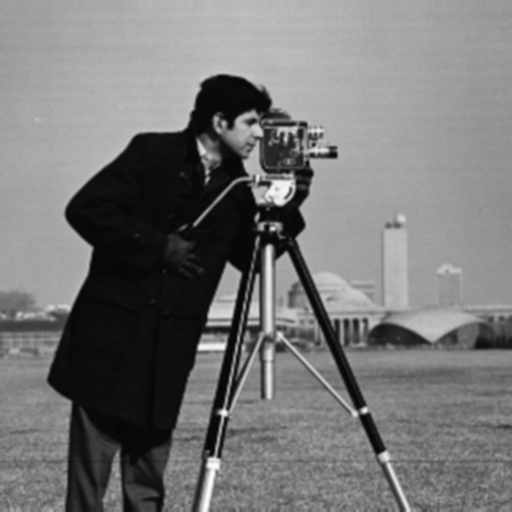

In [41]:

blur_kernel = kernelBank[0][1] 
print("Blur")
opencvOutput = cv2.filter2D(image, -1, blur_kernel)
# axs[i, j].imshow(opencvOutput)
cv2_imshow(opencvOutput)

7*7 Blur


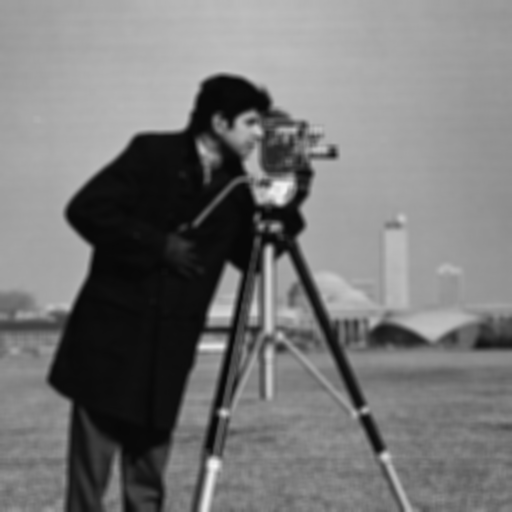

In [25]:
blur_m = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
print("7*7 Blur")
opencvOutput = cv2.filter2D(image, -1, blur_m)
# axs[i, j].imshow(opencvOutput)
cv2_imshow(opencvOutput)

laplacian


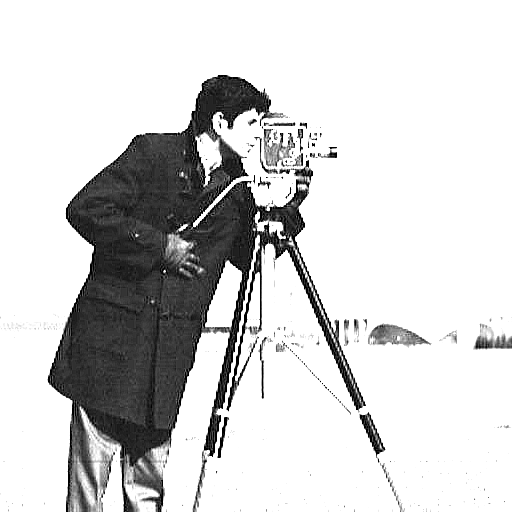

In [51]:

lap = kernelBank[1][1] 
print("laplacian")
opencvOutput = cv2.filter2D(image, -1, lap)
# axs[i, j].imshow(opencvOutput)
cv2_imshow(opencvOutput)

laplacian


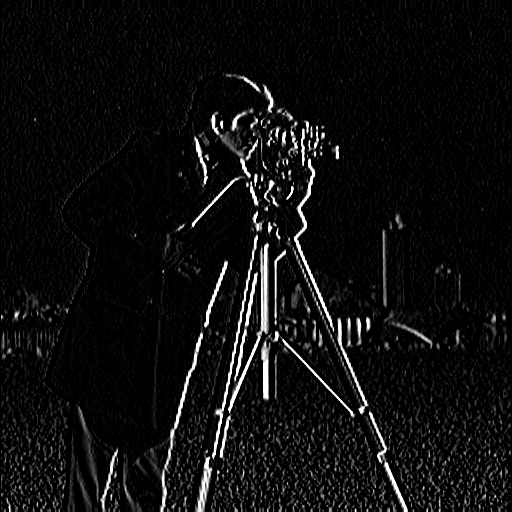

In [42]:

sobel = kernelBank[2][1] 
print("sobel x")
opencvOutput = cv2.filter2D(image, -1, sobel)
# axs[i, j].imshow(opencvOutput)
cv2_imshow(opencvOutput)

sobel y


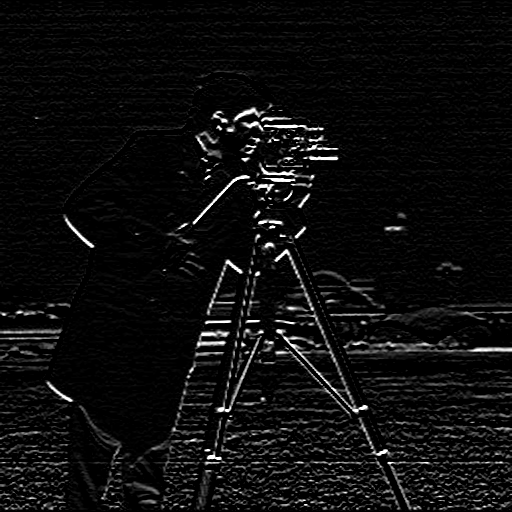

In [49]:

sobel = kernelBank[3][1] 
print("sobel y")
opencvOutput = cv2.filter2D(image, -1, sobel)
# axs[i, j].imshow(opencvOutput)
cv2_imshow(opencvOutput)

# Q3

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 4.8 MB/s 


In [5]:
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from keras_tuner.tuners import RandomSearch, Hyperband

In [6]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Preprocess data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = normalize(X_train)
X_test = normalize(X_test)
X_train = X_train.reshape(-1,32, 32, 3)  # reshaping for convnet

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)



170508288/170498071 [==============================] - 6s 0us/step


In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int('n_layers', 1, 2)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    for i in range(hp.Int('n_connections', 1, 2)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[32, 64, 128, 256])))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation("softmax"))

    lr = hp.Choice("learning_rate",
		  values=[0.0001, 0.001])
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [10]:

tuner = Hyperband(
		build_model,
    max_epochs=8,
		objective="val_accuracy",
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory='CIFAR10_PROJECT',
		factor=3,
		seed=42,
		project_name='KerasTuner')

INFO:tensorflow:Reloading Oracle from existing project CIFAR10_PROJECT/KerasTuner/oracle.json
INFO:tensorflow:Reloading Tuner from CIFAR10_PROJECT/KerasTuner/tuner0.json


In [11]:

NUM_EPOCH = 26
tuner.search(x=X_train,
             y=y_train,
             epochs=NUM_EPOCH,
             batch_size=32,
             validation_data=(X_test, y_test))
tuner.results_summary()

print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

model = tuner.get_best_models(num_models=1)[0]
print (model.summary())
loss, accuracy = model.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)
model.save('hw9.q3')

Trial 11 Complete [00h 06m 48s]
val_accuracy: 0.6442999839782715

Best val_accuracy So Far: 0.7066999872525533
Total elapsed time: 00h 38m 49s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in CIFAR10_PROJECT/KerasTuner
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 32
n_layers: 1
conv_0_units: 128
n_connections: 1
n_nodes: 64
learning_rate: 0.001
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7066999872525533
Trial summary
Hyperparameters:
input_units: 64
n_layers: 1
conv_0_units: 128
n_connections: 1
n_nodes: 64
learning_rate: 0.001
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 2d33f7699b017ea3ea6bec66e22958d8
Score: 0.6933666666348776
Trial summary
Hyperparameters:
input_units: 96
n_layers: 1
conv_0_units: 64
n_connections: 2
n_nodes: 32
learning_rate: 0.001
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


# Q4

In [2]:
import tensorflow as tf


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(20, (7, 7), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(strides=(2, 2), pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(10, (5, 5), activation='relu'))
model.add(tf.keras.layers.LocallyConnected2D(2, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 22, 22, 20)        1000      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 10)          5010      
                                                                 
 locally_connected2d_1 (Loca  (None, 5, 5, 2)          4550      
 llyConnected2D)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               